## 1 factor Hull-White model
The dynamics of short rate $r(t)$ in Hull-hite model is given by

$
dr(t) = \left( \theta(t) - a r(t) \right) dt + \sigma dW(t),
$

where $\theta(t)$ is mean level, $a$ is mean revertion, $\sigma$ is volatility and $W(t)$ is winer process in probaility space(###).
This dynamics is easily solved and the solution is given by

\begin{align}
d(e^{at} r(t) ) &= a r e^{at}dt + e^{at}dr \\
&= e^{at} \theta(t) dt + e^{at} \sigma dW(t).
\end{align}

Thus, with partial integral from 0 to t, short rate is given by 
\begin{align}
r(t) = e^{-at} r(0) + \int_{0}^{t} e^{a(u-t)} \theta(u) dt + \int_{0}^{t} e^{a(u-t)} \sigma dW(u).
\end{align}

The dynamics of this stochastic process is followed by normal distoribution with  mean and variance given by
\begin{align}
& e^{-at} r(0) + \int_{0}^{t} e^{a(u-t)} \theta(u) dt, \\
& \frac{\sigma^{2}}{2a}\left( 1 - e^{-2at} \right).
\end{align}

With short rate determened at time 0 ($f(0, t)$),  mean level is given by 

$
\theta(t) = \frac{\partial f(0, t)}{\partial t}+ a f(0,t) + \frac{\sigma^{2}}{2 a}\left(1 - e^{-2at} \right).
$

Hull White model can be simulated by using these forms, but some are inconvinence such as the differentiating of discount factor as seen in equation of mean level.
Thus, it can be written in easy form in calibration by transforming the stocastic variables to another variable.

We consider the following transforming: $r(t) = \alpha(t) + x(t)$, where $\alpha(t)$ is deterministic and $x(t)$ is stochastic process. 
We transform $r(t)$ in order to satisfy that the dynamics of $x(t) = -a x dt + \sigma dW(t)$ with $x(0) = 0$,  and this form is called OE process.

The solution of OE process is given by

$
x(t) = e^{-at} x(0) + \int_{0}^{t} e^{a(u-t)} \sigma dW(u),
$

with mean $e^{-at} x(0)$ and variance $\frac{\sigma^{2}}{2a}\left( 1 - e^{-2at} \right)$.

The deterministic function $\alpha(t)$ can be expressed by using $f(0,t)$ term not $\partial_{t} f(0,t)$ and the equation is given by

$
\alpha(t) = f(0, t) + \frac{\sigma^{2}}{2 a^2}\left( 1 - e^{-at} \right)^{2}.
$

This equation is calculated by using ODE of $\alpha(t)$ expressed by $d \alpha(t) = \left( \theta(t) - a \alpha(t) \right) dt$ and the equation of mean level with $\partial_{t} f(0,t)$.

Thus, we solve short rate $r(t)$ by using the deterministic function $\alpha(t)$ with $\alpha(0) = r_{0}$ and $x(t)$ with $x(0) = 0$ with normal distribution.

In [1]:
%matplotlib inline
import working_day.return_working_day as wd
import discount_curve.discount_curve as dc
import csv
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
jpy_IR_obj = dc.discount_factor('DF_input/IR_data.csv', 'JPY', '2018/1/18')
jpy_IR_DF_list = jpy_IR_obj.get_DF_list()
DF_jpy = pd.DataFrame(jpy_IR_DF_list, columns=['num', 'date', 'DF'])

In [3]:
class Hull_White:
    def __init__(self, mean_reversion, volatility, DF):
        self._mr = mean_reversion
        self._vol = volatility
        self._df_obj_DF = pd.DataFrame(DF, columns=['num', 'date', 'DF'])  ##note: use [] not {}. Latter is dictionary type and the order is fixed in  alphabetic.
        self._len_DF = len(DF)
        self._dt_obj_base_date = datetime.datetime.strptime(self._df_obj_DF['date'][0], '%Y/%m/%d')
    
    def fwd_rate_ini_array(self):
        time_derivative_array = np.zeros(self._len_DF-1)
        for i in range(self._len_DF - 1):
            delta_time = self.calc_delta_time_differential(self._df_obj_DF['date'][i], self._df_obj_DF['date'][ i +1])
            time_derivative_array[i] = - ( np.log(self._df_obj_DF['DF'][i +1]) - np.log(self._df_obj_DF['DF'][i]) ) / delta_time
        return time_derivative_array
    
    def fwd_rate_ini_array_w_date(self):
        time_derivative_array = self.fwd_rate_ini_array()
        date_array = self._df_obj_DF['date']
        DF_array = self._df_obj_DF['DF']
        fwd_rate_ini_array_w_date = list(zip(date_array, DF_array, time_derivative_array))
        return fwd_rate_ini_array_w_date
        
    def alpha_t_array(self):
        alpha_t = np.zeros(self._len_DF - 1)
        fwd_rate_ini_array = self.fwd_rate_ini_array()
        for i in range(self._len_DF -1 ):
            delta_time = self.calc_delta_time(self._df_obj_DF['date'][i])
            alpha_t[i] = fwd_rate_ini_array[i] + self._vol ** 2 / (2 * self._mr) * (1 - np.exp(- 2 * self._mr * delta_time))
        return alpha_t
    
    def x_t_array(self):
        x_t_array = np.zeros(self._len_DF - 1)
        for i in range(self._len_DF - 1):
            delta_time = self.calc_delta_time(self._df_obj_DF['date'][i])
            variance = self._vol**2/(2*self._mr)*(1 - np.exp(- 2 * self._mr * delta_time))
            x_t_array[i] = np.random.normal(0, variance)
        return x_t_array
    
    def short_rate_array(self):
        short_rate_t = np.zeros(self._len_DF - 1)
        alpha_t_array = self.alpha_t_array()
        x_t_array = self.x_t_array()
        for i in range(self._len_DF - 1):
            short_rate_t[i] = alpha_t_array[i] + x_t_array[i]
        return short_rate_t
    
    def calc_delta_time(self, target_date):
        dt_obj_target_date = datetime.datetime.strptime(target_date, '%Y/%m/%d') 
        delta_time = (dt_obj_target_date - self._dt_obj_base_date).days / 365
        return delta_time
    
    def calc_delta_time_differential(self, base_date, next_date):
        dt_obj_base_date = datetime.datetime.strptime(base_date, '%Y/%m/%d') 
        dt_obj_next_date = datetime.datetime.strptime(next_date, '%Y/%m/%d') 
        delta_time = (dt_obj_next_date - dt_obj_base_date).days / 365
        return delta_time
    
    def zero_rate_array(self):
        zero_rate_array = np.zeros(self._len_DF)
        for i  in range(1, self._len_DF):
            delta_time = self.calc_delta_time(self._df_obj_DF['date'][i])
            zero_rate_array[i] = - (np.log(self._df_obj_DF['DF'][i])) / delta_time
        return zero_rate_array

In [31]:
jpy_IR_obj = dc.discount_factor('DF_input/IR_data.csv', 'JPY', '2018/1/18')
jpy_IR_DF_list = jpy_IR_obj.get_DF_list()
hull_white_obj = Hull_White(0.1, 0.02, jpy_IR_DF_list)
#hull_white_obj.alpha_t_array()
#hull_white_obj.x_t_array()
hull_white_obj.short_rate_array()

array([0.01437472, 0.01461495, 0.01461795, ..., 0.03026308, 0.02929551,
       0.0295407 ])

In [8]:
xrange = np.linspace(0, len(hull_white_obj.short_rate_array())-1, len(hull_white_obj.short_rate_array()))

(0.02, 0.1)

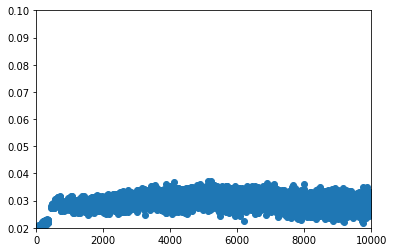

In [32]:
plt.plot(xrange, hull_white_obj.short_rate_array(), 'o')
plt.xlim(0,10000)
plt.ylim(0.02,0.1)

In [82]:
[i for i in hull_white_obj.short_rate_array()]

[0.014374716938093307,
 0.014697468521934588,
 0.014681585138502281,
 0.014767362633069207,
 0.014698285902889805,
 0.014732959642560427,
 0.01454400132552843,
 0.01477740967498677,
 0.01477211098944842,
 0.016303787021617853,
 0.016268402923813954,
 0.016314896349355342,
 0.01558345326030503,
 0.016164854014806024,
 0.016441453401857334,
 0.016347083781901684,
 0.016632593793421423,
 0.016472126864933868,
 0.01720071698116105,
 0.01589953824630174,
 0.016489233379102037,
 0.017182095035546914,
 0.01578176306088434,
 0.017170189543387573,
 0.01569024139150589,
 0.016752984980231513,
 0.017562439979422046,
 0.016717661038340974,
 0.016667053613118824,
 0.017311729671714956,
 0.01796383711486655,
 0.01608791179218146,
 0.017151115892315803,
 0.018051496545079974,
 0.017482799174210924,
 0.017764154752534466,
 0.01777619748024538,
 0.01840507771560183,
 0.017735352392175757,
 0.01825582335960923,
 0.01801115900520429,
 0.017791588365246223,
 0.018261710955477836,
 0.01770125305958886,
 0.

In [66]:
len(hull_white_obj.short_rate_array())

10802

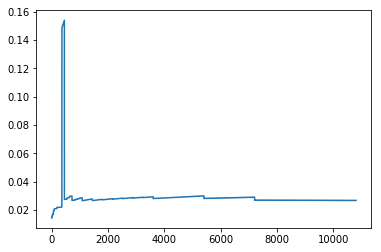

In [24]:
plt.plot(hull_white_obj.fwd_rate_ini_array())

In [24]:
date_1 = datetime.datetime.strptime('2018/3/19', '%Y/%m/%d')
date_2 = datetime.datetime.strptime('2018/4/19', '%Y/%m/%d')
(date_2 - date_1).days

31

In [20]:
pd.DataFrame(jpy_IR_obj.get_DF_list(), columns=['index', 'date', 'DF']).to_csv('DF.csv')

In [45]:
for i, j in enumerate(hull_white_obj.fwd_rate_ini_array_w_date()):        

0 2018/01/18
1 2018/01/19
2 2018/01/20
3 2018/01/21
4 2018/01/22
5 2018/01/23
6 2018/01/24
7 2018/01/25
8 2018/01/26
9 2018/01/27
10 2018/01/28
11 2018/01/29
12 2018/01/30
13 2018/01/31
14 2018/02/01
15 2018/02/02
16 2018/02/03
17 2018/02/04
18 2018/02/05
19 2018/02/06
20 2018/02/07
21 2018/02/08
22 2018/02/09
23 2018/02/10
24 2018/02/11
25 2018/02/12
26 2018/02/13
27 2018/02/14
28 2018/02/15
29 2018/02/16
30 2018/02/17
31 2018/02/18
32 2018/02/19
33 2018/02/20
34 2018/02/21
35 2018/02/22
36 2018/02/23
37 2018/02/24
38 2018/02/25
39 2018/02/26
40 2018/02/27
41 2018/02/28
42 2018/03/01
43 2018/03/02
44 2018/03/03
45 2018/03/04
46 2018/03/05
47 2018/03/06
48 2018/03/07
49 2018/03/08
50 2018/03/09
51 2018/03/10
52 2018/03/11
53 2018/03/12
54 2018/03/13
55 2018/03/14
56 2018/03/15
57 2018/03/16
58 2018/03/17
59 2018/03/18
60 2018/03/19
61 2018/03/20
62 2018/03/21
63 2018/03/22
64 2018/03/23
65 2018/03/24
66 2018/03/25
67 2018/03/26
68 2018/03/27
69 2018/03/28
70 2018/03/29
71 2018/03/30
72

1000 2020/10/14
1001 2020/10/15
1002 2020/10/16
1003 2020/10/17
1004 2020/10/18
1005 2020/10/19
1006 2020/10/20
1007 2020/10/21
1008 2020/10/22
1009 2020/10/23
1010 2020/10/24
1011 2020/10/25
1012 2020/10/26
1013 2020/10/27
1014 2020/10/28
1015 2020/10/29
1016 2020/10/30
1017 2020/10/31
1018 2020/11/01
1019 2020/11/02
1020 2020/11/03
1021 2020/11/04
1022 2020/11/05
1023 2020/11/06
1024 2020/11/07
1025 2020/11/08
1026 2020/11/09
1027 2020/11/10
1028 2020/11/11
1029 2020/11/12
1030 2020/11/13
1031 2020/11/14
1032 2020/11/15
1033 2020/11/16
1034 2020/11/17
1035 2020/11/18
1036 2020/11/19
1037 2020/11/20
1038 2020/11/21
1039 2020/11/22
1040 2020/11/23
1041 2020/11/24
1042 2020/11/25
1043 2020/11/26
1044 2020/11/27
1045 2020/11/28
1046 2020/11/29
1047 2020/11/30
1048 2020/12/01
1049 2020/12/02
1050 2020/12/03
1051 2020/12/04
1052 2020/12/05
1053 2020/12/06
1054 2020/12/07
1055 2020/12/08
1056 2020/12/09
1057 2020/12/10
1058 2020/12/11
1059 2020/12/12
1060 2020/12/13
1061 2020/12/14
1062 202

1745 2022/10/29
1746 2022/10/30
1747 2022/10/31
1748 2022/11/01
1749 2022/11/02
1750 2022/11/03
1751 2022/11/04
1752 2022/11/05
1753 2022/11/06
1754 2022/11/07
1755 2022/11/08
1756 2022/11/09
1757 2022/11/10
1758 2022/11/11
1759 2022/11/12
1760 2022/11/13
1761 2022/11/14
1762 2022/11/15
1763 2022/11/16
1764 2022/11/17
1765 2022/11/18
1766 2022/11/19
1767 2022/11/20
1768 2022/11/21
1769 2022/11/22
1770 2022/11/23
1771 2022/11/24
1772 2022/11/25
1773 2022/11/26
1774 2022/11/27
1775 2022/11/28
1776 2022/11/29
1777 2022/11/30
1778 2022/12/01
1779 2022/12/02
1780 2022/12/03
1781 2022/12/04
1782 2022/12/05
1783 2022/12/06
1784 2022/12/07
1785 2022/12/08
1786 2022/12/09
1787 2022/12/10
1788 2022/12/11
1789 2022/12/12
1790 2022/12/13
1791 2022/12/14
1792 2022/12/15
1793 2022/12/16
1794 2022/12/17
1795 2022/12/18
1796 2022/12/19
1797 2022/12/20
1798 2022/12/21
1799 2022/12/22
1800 2022/12/23
1801 2022/12/24
1802 2022/12/25
1803 2022/12/26
1804 2022/12/27
1805 2022/12/28
1806 2022/12/29
1807 202

2414 2024/08/28
2415 2024/08/29
2416 2024/08/30
2417 2024/08/31
2418 2024/09/01
2419 2024/09/02
2420 2024/09/03
2421 2024/09/04
2422 2024/09/05
2423 2024/09/06
2424 2024/09/07
2425 2024/09/08
2426 2024/09/09
2427 2024/09/10
2428 2024/09/11
2429 2024/09/12
2430 2024/09/13
2431 2024/09/14
2432 2024/09/15
2433 2024/09/16
2434 2024/09/17
2435 2024/09/18
2436 2024/09/19
2437 2024/09/20
2438 2024/09/21
2439 2024/09/22
2440 2024/09/23
2441 2024/09/24
2442 2024/09/25
2443 2024/09/26
2444 2024/09/27
2445 2024/09/28
2446 2024/09/29
2447 2024/09/30
2448 2024/10/01
2449 2024/10/02
2450 2024/10/03
2451 2024/10/04
2452 2024/10/05
2453 2024/10/06
2454 2024/10/07
2455 2024/10/08
2456 2024/10/09
2457 2024/10/10
2458 2024/10/11
2459 2024/10/12
2460 2024/10/13
2461 2024/10/14
2462 2024/10/15
2463 2024/10/16
2464 2024/10/17
2465 2024/10/18
2466 2024/10/19
2467 2024/10/20
2468 2024/10/21
2469 2024/10/22
2470 2024/10/23
2471 2024/10/24
2472 2024/10/25
2473 2024/10/26
2474 2024/10/27
2475 2024/10/28
2476 202

3212 2026/11/04
3213 2026/11/05
3214 2026/11/06
3215 2026/11/07
3216 2026/11/08
3217 2026/11/09
3218 2026/11/10
3219 2026/11/11
3220 2026/11/12
3221 2026/11/13
3222 2026/11/14
3223 2026/11/15
3224 2026/11/16
3225 2026/11/17
3226 2026/11/18
3227 2026/11/19
3228 2026/11/20
3229 2026/11/21
3230 2026/11/22
3231 2026/11/23
3232 2026/11/24
3233 2026/11/25
3234 2026/11/26
3235 2026/11/27
3236 2026/11/28
3237 2026/11/29
3238 2026/11/30
3239 2026/12/01
3240 2026/12/02
3241 2026/12/03
3242 2026/12/04
3243 2026/12/05
3244 2026/12/06
3245 2026/12/07
3246 2026/12/08
3247 2026/12/09
3248 2026/12/10
3249 2026/12/11
3250 2026/12/12
3251 2026/12/13
3252 2026/12/14
3253 2026/12/15
3254 2026/12/16
3255 2026/12/17
3256 2026/12/18
3257 2026/12/19
3258 2026/12/20
3259 2026/12/21
3260 2026/12/22
3261 2026/12/23
3262 2026/12/24
3263 2026/12/25
3264 2026/12/26
3265 2026/12/27
3266 2026/12/28
3267 2026/12/29
3268 2026/12/30
3269 2026/12/31
3270 2027/01/01
3271 2027/01/02
3272 2027/01/03
3273 2027/01/04
3274 202

3944 2028/11/05
3945 2028/11/06
3946 2028/11/07
3947 2028/11/08
3948 2028/11/09
3949 2028/11/10
3950 2028/11/11
3951 2028/11/12
3952 2028/11/13
3953 2028/11/14
3954 2028/11/15
3955 2028/11/16
3956 2028/11/17
3957 2028/11/18
3958 2028/11/19
3959 2028/11/20
3960 2028/11/21
3961 2028/11/22
3962 2028/11/23
3963 2028/11/24
3964 2028/11/25
3965 2028/11/26
3966 2028/11/27
3967 2028/11/28
3968 2028/11/29
3969 2028/11/30
3970 2028/12/01
3971 2028/12/02
3972 2028/12/03
3973 2028/12/04
3974 2028/12/05
3975 2028/12/06
3976 2028/12/07
3977 2028/12/08
3978 2028/12/09
3979 2028/12/10
3980 2028/12/11
3981 2028/12/12
3982 2028/12/13
3983 2028/12/14
3984 2028/12/15
3985 2028/12/16
3986 2028/12/17
3987 2028/12/18
3988 2028/12/19
3989 2028/12/20
3990 2028/12/21
3991 2028/12/22
3992 2028/12/23
3993 2028/12/24
3994 2028/12/25
3995 2028/12/26
3996 2028/12/27
3997 2028/12/28
3998 2028/12/29
3999 2028/12/30
4000 2028/12/31
4001 2029/01/01
4002 2029/01/02
4003 2029/01/03
4004 2029/01/04
4005 2029/01/05
4006 202

4482 2030/04/27
4483 2030/04/28
4484 2030/04/29
4485 2030/04/30
4486 2030/05/01
4487 2030/05/02
4488 2030/05/03
4489 2030/05/04
4490 2030/05/05
4491 2030/05/06
4492 2030/05/07
4493 2030/05/08
4494 2030/05/09
4495 2030/05/10
4496 2030/05/11
4497 2030/05/12
4498 2030/05/13
4499 2030/05/14
4500 2030/05/15
4501 2030/05/16
4502 2030/05/17
4503 2030/05/18
4504 2030/05/19
4505 2030/05/20
4506 2030/05/21
4507 2030/05/22
4508 2030/05/23
4509 2030/05/24
4510 2030/05/25
4511 2030/05/26
4512 2030/05/27
4513 2030/05/28
4514 2030/05/29
4515 2030/05/30
4516 2030/05/31
4517 2030/06/01
4518 2030/06/02
4519 2030/06/03
4520 2030/06/04
4521 2030/06/05
4522 2030/06/06
4523 2030/06/07
4524 2030/06/08
4525 2030/06/09
4526 2030/06/10
4527 2030/06/11
4528 2030/06/12
4529 2030/06/13
4530 2030/06/14
4531 2030/06/15
4532 2030/06/16
4533 2030/06/17
4534 2030/06/18
4535 2030/06/19
4536 2030/06/20
4537 2030/06/21
4538 2030/06/22
4539 2030/06/23
4540 2030/06/24
4541 2030/06/25
4542 2030/06/26
4543 2030/06/27
4544 203

5227 2032/05/11
5228 2032/05/12
5229 2032/05/13
5230 2032/05/14
5231 2032/05/15
5232 2032/05/16
5233 2032/05/17
5234 2032/05/18
5235 2032/05/19
5236 2032/05/20
5237 2032/05/21
5238 2032/05/22
5239 2032/05/23
5240 2032/05/24
5241 2032/05/25
5242 2032/05/26
5243 2032/05/27
5244 2032/05/28
5245 2032/05/29
5246 2032/05/30
5247 2032/05/31
5248 2032/06/01
5249 2032/06/02
5250 2032/06/03
5251 2032/06/04
5252 2032/06/05
5253 2032/06/06
5254 2032/06/07
5255 2032/06/08
5256 2032/06/09
5257 2032/06/10
5258 2032/06/11
5259 2032/06/12
5260 2032/06/13
5261 2032/06/14
5262 2032/06/15
5263 2032/06/16
5264 2032/06/17
5265 2032/06/18
5266 2032/06/19
5267 2032/06/20
5268 2032/06/21
5269 2032/06/22
5270 2032/06/23
5271 2032/06/24
5272 2032/06/25
5273 2032/06/26
5274 2032/06/27
5275 2032/06/28
5276 2032/06/29
5277 2032/06/30
5278 2032/07/01
5279 2032/07/02
5280 2032/07/03
5281 2032/07/04
5282 2032/07/05
5283 2032/07/06
5284 2032/07/07
5285 2032/07/08
5286 2032/07/09
5287 2032/07/10
5288 2032/07/11
5289 203

5829 2034/01/03
5830 2034/01/04
5831 2034/01/05
5832 2034/01/06
5833 2034/01/07
5834 2034/01/08
5835 2034/01/09
5836 2034/01/10
5837 2034/01/11
5838 2034/01/12
5839 2034/01/13
5840 2034/01/14
5841 2034/01/15
5842 2034/01/16
5843 2034/01/17
5844 2034/01/18
5845 2034/01/19
5846 2034/01/20
5847 2034/01/21
5848 2034/01/22
5849 2034/01/23
5850 2034/01/24
5851 2034/01/25
5852 2034/01/26
5853 2034/01/27
5854 2034/01/28
5855 2034/01/29
5856 2034/01/30
5857 2034/01/31
5858 2034/02/01
5859 2034/02/02
5860 2034/02/03
5861 2034/02/04
5862 2034/02/05
5863 2034/02/06
5864 2034/02/07
5865 2034/02/08
5866 2034/02/09
5867 2034/02/10
5868 2034/02/11
5869 2034/02/12
5870 2034/02/13
5871 2034/02/14
5872 2034/02/15
5873 2034/02/16
5874 2034/02/17
5875 2034/02/18
5876 2034/02/19
5877 2034/02/20
5878 2034/02/21
5879 2034/02/22
5880 2034/02/23
5881 2034/02/24
5882 2034/02/25
5883 2034/02/26
5884 2034/02/27
5885 2034/02/28
5886 2034/03/01
5887 2034/03/02
5888 2034/03/03
5889 2034/03/04
5890 2034/03/05
5891 203

6518 2035/11/23
6519 2035/11/24
6520 2035/11/25
6521 2035/11/26
6522 2035/11/27
6523 2035/11/28
6524 2035/11/29
6525 2035/11/30
6526 2035/12/01
6527 2035/12/02
6528 2035/12/03
6529 2035/12/04
6530 2035/12/05
6531 2035/12/06
6532 2035/12/07
6533 2035/12/08
6534 2035/12/09
6535 2035/12/10
6536 2035/12/11
6537 2035/12/12
6538 2035/12/13
6539 2035/12/14
6540 2035/12/15
6541 2035/12/16
6542 2035/12/17
6543 2035/12/18
6544 2035/12/19
6545 2035/12/20
6546 2035/12/21
6547 2035/12/22
6548 2035/12/23
6549 2035/12/24
6550 2035/12/25
6551 2035/12/26
6552 2035/12/27
6553 2035/12/28
6554 2035/12/29
6555 2035/12/30
6556 2035/12/31
6557 2036/01/01
6558 2036/01/02
6559 2036/01/03
6560 2036/01/04
6561 2036/01/05
6562 2036/01/06
6563 2036/01/07
6564 2036/01/08
6565 2036/01/09
6566 2036/01/10
6567 2036/01/11
6568 2036/01/12
6569 2036/01/13
6570 2036/01/14
6571 2036/01/15
6572 2036/01/16
6573 2036/01/17
6574 2036/01/18
6575 2036/01/19
6576 2036/01/20
6577 2036/01/21
6578 2036/01/22
6579 2036/01/23
6580 203

7271 2037/12/15
7272 2037/12/16
7273 2037/12/17
7274 2037/12/18
7275 2037/12/19
7276 2037/12/20
7277 2037/12/21
7278 2037/12/22
7279 2037/12/23
7280 2037/12/24
7281 2037/12/25
7282 2037/12/26
7283 2037/12/27
7284 2037/12/28
7285 2037/12/29
7286 2037/12/30
7287 2037/12/31
7288 2038/01/01
7289 2038/01/02
7290 2038/01/03
7291 2038/01/04
7292 2038/01/05
7293 2038/01/06
7294 2038/01/07
7295 2038/01/08
7296 2038/01/09
7297 2038/01/10
7298 2038/01/11
7299 2038/01/12
7300 2038/01/13
7301 2038/01/14
7302 2038/01/15
7303 2038/01/16
7304 2038/01/17
7305 2038/01/18
7306 2038/01/19
7307 2038/01/20
7308 2038/01/21
7309 2038/01/22
7310 2038/01/23
7311 2038/01/24
7312 2038/01/25
7313 2038/01/26
7314 2038/01/27
7315 2038/01/28
7316 2038/01/29
7317 2038/01/30
7318 2038/01/31
7319 2038/02/01
7320 2038/02/02
7321 2038/02/03
7322 2038/02/04
7323 2038/02/05
7324 2038/02/06
7325 2038/02/07
7326 2038/02/08
7327 2038/02/09
7328 2038/02/10
7329 2038/02/11
7330 2038/02/12
7331 2038/02/13
7332 2038/02/14
7333 203

7907 2039/09/12
7908 2039/09/13
7909 2039/09/14
7910 2039/09/15
7911 2039/09/16
7912 2039/09/17
7913 2039/09/18
7914 2039/09/19
7915 2039/09/20
7916 2039/09/21
7917 2039/09/22
7918 2039/09/23
7919 2039/09/24
7920 2039/09/25
7921 2039/09/26
7922 2039/09/27
7923 2039/09/28
7924 2039/09/29
7925 2039/09/30
7926 2039/10/01
7927 2039/10/02
7928 2039/10/03
7929 2039/10/04
7930 2039/10/05
7931 2039/10/06
7932 2039/10/07
7933 2039/10/08
7934 2039/10/09
7935 2039/10/10
7936 2039/10/11
7937 2039/10/12
7938 2039/10/13
7939 2039/10/14
7940 2039/10/15
7941 2039/10/16
7942 2039/10/17
7943 2039/10/18
7944 2039/10/19
7945 2039/10/20
7946 2039/10/21
7947 2039/10/22
7948 2039/10/23
7949 2039/10/24
7950 2039/10/25
7951 2039/10/26
7952 2039/10/27
7953 2039/10/28
7954 2039/10/29
7955 2039/10/30
7956 2039/10/31
7957 2039/11/01
7958 2039/11/02
7959 2039/11/03
7960 2039/11/04
7961 2039/11/05
7962 2039/11/06
7963 2039/11/07
7964 2039/11/08
7965 2039/11/09
7966 2039/11/10
7967 2039/11/11
7968 2039/11/12
7969 203

8766 2042/01/18
8767 2042/01/19
8768 2042/01/20
8769 2042/01/21
8770 2042/01/22
8771 2042/01/23
8772 2042/01/24
8773 2042/01/25
8774 2042/01/26
8775 2042/01/27
8776 2042/01/28
8777 2042/01/29
8778 2042/01/30
8779 2042/01/31
8780 2042/02/01
8781 2042/02/02
8782 2042/02/03
8783 2042/02/04
8784 2042/02/05
8785 2042/02/06
8786 2042/02/07
8787 2042/02/08
8788 2042/02/09
8789 2042/02/10
8790 2042/02/11
8791 2042/02/12
8792 2042/02/13
8793 2042/02/14
8794 2042/02/15
8795 2042/02/16
8796 2042/02/17
8797 2042/02/18
8798 2042/02/19
8799 2042/02/20
8800 2042/02/21
8801 2042/02/22
8802 2042/02/23
8803 2042/02/24
8804 2042/02/25
8805 2042/02/26
8806 2042/02/27
8807 2042/02/28
8808 2042/03/01
8809 2042/03/02
8810 2042/03/03
8811 2042/03/04
8812 2042/03/05
8813 2042/03/06
8814 2042/03/07
8815 2042/03/08
8816 2042/03/09
8817 2042/03/10
8818 2042/03/11
8819 2042/03/12
8820 2042/03/13
8821 2042/03/14
8822 2042/03/15
8823 2042/03/16
8824 2042/03/17
8825 2042/03/18
8826 2042/03/19
8827 2042/03/20
8828 204

9523 2044/02/14
9524 2044/02/15
9525 2044/02/16
9526 2044/02/17
9527 2044/02/18
9528 2044/02/19
9529 2044/02/20
9530 2044/02/21
9531 2044/02/22
9532 2044/02/23
9533 2044/02/24
9534 2044/02/25
9535 2044/02/26
9536 2044/02/27
9537 2044/02/28
9538 2044/02/29
9539 2044/03/01
9540 2044/03/02
9541 2044/03/03
9542 2044/03/04
9543 2044/03/05
9544 2044/03/06
9545 2044/03/07
9546 2044/03/08
9547 2044/03/09
9548 2044/03/10
9549 2044/03/11
9550 2044/03/12
9551 2044/03/13
9552 2044/03/14
9553 2044/03/15
9554 2044/03/16
9555 2044/03/17
9556 2044/03/18
9557 2044/03/19
9558 2044/03/20
9559 2044/03/21
9560 2044/03/22
9561 2044/03/23
9562 2044/03/24
9563 2044/03/25
9564 2044/03/26
9565 2044/03/27
9566 2044/03/28
9567 2044/03/29
9568 2044/03/30
9569 2044/03/31
9570 2044/04/01
9571 2044/04/02
9572 2044/04/03
9573 2044/04/04
9574 2044/04/05
9575 2044/04/06
9576 2044/04/07
9577 2044/04/08
9578 2044/04/09
9579 2044/04/10
9580 2044/04/11
9581 2044/04/12
9582 2044/04/13
9583 2044/04/14
9584 2044/04/15
9585 204

10131 2045/10/14
10132 2045/10/15
10133 2045/10/16
10134 2045/10/17
10135 2045/10/18
10136 2045/10/19
10137 2045/10/20
10138 2045/10/21
10139 2045/10/22
10140 2045/10/23
10141 2045/10/24
10142 2045/10/25
10143 2045/10/26
10144 2045/10/27
10145 2045/10/28
10146 2045/10/29
10147 2045/10/30
10148 2045/10/31
10149 2045/11/01
10150 2045/11/02
10151 2045/11/03
10152 2045/11/04
10153 2045/11/05
10154 2045/11/06
10155 2045/11/07
10156 2045/11/08
10157 2045/11/09
10158 2045/11/10
10159 2045/11/11
10160 2045/11/12
10161 2045/11/13
10162 2045/11/14
10163 2045/11/15
10164 2045/11/16
10165 2045/11/17
10166 2045/11/18
10167 2045/11/19
10168 2045/11/20
10169 2045/11/21
10170 2045/11/22
10171 2045/11/23
10172 2045/11/24
10173 2045/11/25
10174 2045/11/26
10175 2045/11/27
10176 2045/11/28
10177 2045/11/29
10178 2045/11/30
10179 2045/12/01
10180 2045/12/02
10181 2045/12/03
10182 2045/12/04
10183 2045/12/05
10184 2045/12/06
10185 2045/12/07
10186 2045/12/08
10187 2045/12/09
10188 2045/12/10
10189 2045/12/